In [32]:
import numpy as np
import matplotlib.pyplot as plt
import netket as nk
from scipy.linalg import eigh
from collections import defaultdict, Counter
from functools import reduce


## Synthetic Measurement Dataset by direct sampling

In [2]:
# Define Pauli matrices
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

### Helper Functions

In [3]:
def tensor_product(matrices):
    """Compute tensor product of a list of matrices."""
    result = matrices[0]
    for mat in matrices[1:]:
        result = np.kron(result, mat)
    return result

def apply_measurement_rotation(state, basis_string):
    """
    Apply unitary rotation to measure in specified basis.
    basis_string: string like 'XIYIZI' where each char is I, X, Y, or Z
    """
    n_qubits = int(np.log2(len(state)))
    
    # Build rotation matrices
    H_gate = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
    S_dag = np.array([[1, 0], [0, -1j]], dtype=complex)
    
    rotation_matrices = []
    for base in basis_string:
        if base == 'Z' or base == 'I':
            rotation_matrices.append(I)
        elif base == 'X':
            rotation_matrices.append(H_gate)
        elif base == 'Y':
            rotation_matrices.append(H_gate @ S_dag)
        else:
            raise ValueError(f"Unknown basis character: {base}")
    
    U = tensor_product(rotation_matrices)
    return U @ state

def sample_bitstring(state_amplitudes):
    """Sample a bitstring from quantum state probability distribution."""
    probabilities = np.abs(state_amplitudes)**2
    probabilities = probabilities / np.sum(probabilities)
    
    n_qubits = int(np.log2(len(state_amplitudes)))
    outcome = np.random.choice(len(state_amplitudes), p=probabilities)
    
    bitstring = format(outcome, f'0{n_qubits}b')
    return bitstring

def OperatorFromString(op_string):
    """Convert Pauli string to matrix and sites."""
    pauli_map = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
    OpList = []
    Sites = []
    
    for k, char in enumerate(op_string):
        if char in pauli_map:
            OpList.append(pauli_map[char])
            Sites.append(k)
        else:
            raise ValueError(f"Unknown Pauli character: {char}")
    
    return Sites, reduce(np.kron, OpList)

def MeasurementRotationFromString(basis_string):
    """
    Convert basis string to rotation operator matrix for measurements.
    
    For measurement bases, we need rotation unitaries, not Pauli operators:
    - I or Z: Identity (no rotation, measure in computational basis)
    - X: Hadamard (rotation to X eigenbasis)
    - Y: S†H (rotation to Y eigenbasis)
    """
    
    H_gate = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
    S_dag = np.array([[1, 0], [0, -1j]], dtype=complex)
    U_Y = H_gate @ S_dag
    
    rotation_map = {
        'I': I,
        'Z': I,      # No rotation for Z basis
        'X': H_gate, # Hadamard for X basis
        'Y': U_Y     # S†H for Y basis
    }
    
    OpList = []
    Sites = []
    
    for k, char in enumerate(basis_string):
        if char in rotation_map:
            OpList.append(rotation_map[char])
            Sites.append(k)
        else:
            raise ValueError(f"Unknown basis character: {char}")
    
    return Sites, reduce(np.kron, OpList)

def BuildBases(hilbert, basis_strings):
    """
    Build explicit LocalOperator objects for measurement bases.
    basis_strings: array of strings like ['XIYIZI', 'ZZIIIZ', ...]

    """
    base_ops = []
    
    for basis_string in basis_strings:
        basis_string = str(basis_string)  # Convert numpy.str_ if needed
        sites, operator = MeasurementRotationFromString(basis_string)
        base_operator = nk.operator.LocalOperator(hilbert, operator, sites)
        base_ops.append(base_operator)
    
    return np.array(base_ops, dtype=object)

### Main Function

In [4]:
def generate_beh2_measurement_dataset(
    ground_state,
    pauli_strings,
    coefficients,
    n_samples=128000,
    seed=42
):
    """
    Generate synthetic measurement dataset for BeH2.
    
    Args:
        ground_state: Exact ground state vector from diagonalization
        pauli_strings: List of Pauli strings from Hamiltonian decomposition
        coefficients: Corresponding coefficients
        n_samples: Number of measurements to generate
        seed: Random seed
        
    Returns:
        bitstrings: Array of measurement outcomes
        basis_strings: Array of measurement bases
        statistics: Dict with dataset statistics
    """
    np.random.seed(seed)
    n_qubits = int(np.log2(len(ground_state)))
    
    print(f"Generating BeH2 measurement dataset...")
    print(f"  Ground state: {len(ground_state)} dimensional")
    print(f"  Number of qubits: {n_qubits}")
    print(f"  Hamiltonian terms: {len(pauli_strings)}")
    print(f"  Target samples: {n_samples:,}")
    
    # Convert I's to Z's in all Pauli strings
    modified_terms = []
    for pauli, coeff in zip(pauli_strings, coefficients):
        pauli_str = str(pauli)
        # Skip if empty
        if len(pauli_str) == 0:
            print(f"  Skipping empty Pauli term with coefficient {coeff}")
            continue
        # Replace all I's with Z's
        modified_str = pauli_str.replace('I', 'Z')
        modified_terms.append(modified_str)
    
    print(f"  Modified terms (I->Z): {len(modified_terms)}")
    print(f"  Unique Pauli terms: {len(set(modified_terms))}")
    
    if len(modified_terms) == 0:
        raise ValueError("No valid Pauli terms found!")
    
    # Generate measurement samples
    bitstrings = []
    basis_strings = []
    basis_counter = Counter()
    
    print(f"\nGenerating {n_samples:,} measurement samples...")
    for i in range(n_samples):
        # Uniformly sample a Pauli term
        basis_string = np.random.choice(modified_terms)
        basis_counter[basis_string] += 1
        
        # Apply rotation and sample
        rotated_state = apply_measurement_rotation(ground_state, basis_string)
        bitstring = sample_bitstring(rotated_state)
        
        bitstrings.append(bitstring)
        basis_strings.append(basis_string)
        
        if (i + 1) % (n_samples // 10) == 0:
            print(f"  Progress: {i + 1:,}/{n_samples:,}")
    
    bitstrings = np.array(bitstrings)
    basis_strings = np.array(basis_strings)
    
    # Statistics
    unique_bases = len(set(basis_strings))
    unique_bitstrings = len(set(bitstrings))
    
    print(f"\n✓ Dataset generated!")
    print(f"  Total samples: {len(bitstrings):,}")
    print(f"  Unique bases used: {unique_bases}")
    print(f"  Unique bitstrings: {unique_bitstrings}")
    print(f"  Average samples per basis: {n_samples / unique_bases:.1f}")
    
    # Check coverage
    expected_unique = len(set(modified_terms))
    if unique_bases < expected_unique:
        missing = expected_unique - unique_bases
        print(f"  ⚠ Warning: Missing {missing} basis types (expected {expected_unique})")
    else:
        print(f"  ✓ All {expected_unique} unique basis types covered!")
    
    # Show top 5 most common bases
    print(f"\n  Top 5 most sampled bases:")
    for basis, count in basis_counter.most_common(5):
        print(f"    {basis}: {count} times ({100*count/n_samples:.2f}%)")
    
    statistics = {
        'n_samples': len(bitstrings),
        'unique_bases': unique_bases,
        'unique_bitstrings': unique_bitstrings,
        'expected_unique_bases': expected_unique,
        'basis_counts': dict(basis_counter)
    }
    
    return bitstrings, basis_strings, statistics

### Generation:

Given: 
Pauli Words and coefficients of the qubit Hamiltonian of $BeH_2$

Do:
Create a measurement dataset of outcomes (+bases) of measuring in these bases to train a neural network to perform observable estimation.

How we do it:
- Build hamiltonian from Pauli words + coefficients, then obtain ground state by exact diagonalization
- Iterate over these 3 steps M (n_samples) times:
    - Randomly select a Pauli Word from the given set
    - Apply the corresponding rotation to the ground state (apply tensor product of rotation matrices) 
    - Then sample a bitstring from the rotated ground state (sample from the amplitudes then convert to binary)


## Synthetic Measurement Dataset from Simulated Quantum Circuit

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

### Helper Functions

In [ ]:
def create_state_preparation_circuit(ground_state, n_qubits):
    """
    Create a quantum circuit that prepares the exact ground state.
    Uses Qiskit's initialize method for state preparation.
    
    Args:
        ground_state: Ground state amplitudes (2^n_qubits dimensional vector)
        n_qubits: Number of qubits
        
    Returns:
        QuantumCircuit with state preparation
    """
    qc = QuantumCircuit(n_qubits)
        
    # Normalize the state (should already be normalized, but just in case)
    normalized_state = ground_state / np.linalg.norm(ground_state)
    
    # Initialize the quantum state
    qc.initialize(normalized_state, range(n_qubits))
    
    return qc

def apply_measurement_basis_rotation(qc, basis_string):
    """
    Apply basis rotation gates to measure in specified Pauli basis.
    
    Args:
        qc: QuantumCircuit to apply rotations to
        basis_string: String like 'XZYZZI' where each char is X, Y, or Z
        
    Note: Z and I both measure in computational basis (no rotation needed)
          X requires Hadamard
          Y requires S†H
    """
    n_qubits = qc.num_qubits
    
    for qubit_idx, basis_char in enumerate(basis_string):
        if basis_char == 'X':
            qc.h(qubit_idx)  # Hadamard for X basis
        elif basis_char == 'Y':
            qc.sdg(qubit_idx)  # S† (inverse S gate)
            qc.h(qubit_idx)     # Then Hadamard
        elif basis_char in ['Z', 'I']:  ## this part is what caused the first bug in the other dataset preparation
            pass  # No rotation needed for Z basis (computational basis)
        else:
            raise ValueError(f"Unknown basis character: {basis_char}")
    
    return qc


# Function to build the base operators properly -- SAVIOUR RIGHT HERE!
def BuildBases(hilbert,bases_array):
    base_ops = []
    
    for basis_string in bases_array:
        basis_string = str(basis_string)
        sites,operator = MeasurementRotationFromString(basis_string)
        base_operator = nk.operator.LocalOperator(hilbert,operator,sites)
        base_ops.append(base_operator)
    return np.array(base_ops,dtype=object)

### Main Function

In [9]:
def generate_beh2_circuit_measurement_dataset(
    ground_state,
    pauli_strings,
    coefficients,
    n_samples=128000,
    seed=42
    # shots_per_circuit=512 ## don't need now number of times the same circuit is created, and its qubits measured
):
    """
    Generate measurement dataset using Qiskit quantum circuits.
    
    Args:
        ground_state: Exact ground state vector
        pauli_strings: List of Pauli strings from Hamiltonian
        coefficients: Corresponding coefficients
        n_samples: Total number of measurements to generate
        seed: Random seed
        shots_per_circuit: Number of shots to take per circuit execution
        
    Returns:
        bitstrings: Array of measurement outcomes
        basis_strings: Array of measurement bases
        statistics: Dict with dataset statistics
    """
    np.random.seed(seed)
    n_qubits = int(np.log2(len(ground_state)))
    
    print(f"Generating BeH2 circuit-based measurement dataset...")
    print(f"  Ground state: {len(ground_state)} dimensional")
    print(f"  Number of qubits: {n_qubits}")
    print(f"  Hamiltonian terms: {len(pauli_strings)}")
    print(f"  Target samples: {n_samples:,}")

    
    # Convert I's to Z's in all Pauli strings
    modified_terms = []
    for pauli, coeff in zip(pauli_strings, coefficients):
        pauli_str = str(pauli)
        if len(pauli_str) == 0:
            print(f"  Skipping empty Pauli term with coefficient {coeff}")
            continue
        # Replace all I's with Z's
        modified_str = pauli_str.replace('I', 'Z')
        modified_terms.append(modified_str)
    
    print(f"  Modified terms (I->Z): {len(modified_terms)}")
    print(f"  Unique Pauli terms: {len(set(modified_terms))}")
    
    if len(modified_terms) == 0:
        raise ValueError("No valid Pauli terms found!")
    
    # Setup Qiskit simulator
    simulator = AerSimulator(method='statevector', seed_simulator=seed)
    
    # Generate measurement samples
    all_bitstrings = []
    all_basis_strings = []
    basis_counter = Counter()
    
    # Count occurrences of each basis (to preserve Hamiltonian weighting)
    basis_weights = Counter(modified_terms)
    unique_bases = list(basis_weights.keys())
    n_unique_bases = len(unique_bases)
    total_weight = sum(basis_weights.values())
    
    print(f"\nWeighted stratified sampling:")
    print(f"  Unique bases: {n_unique_bases}")
    print(f"  Total Hamiltonian terms: {total_weight}")
    print(f"  Target samples: {n_samples}")

    # Distribute shots proportionally to basis weights
    shots_allocation = {}
    total_allocated = 0

    for basis in unique_bases:
        weight = basis_weights[basis]
        shots_allocation[basis] = int(n_samples * weight / total_weight)
        total_allocated += shots_allocation[basis]

    # Distribute remainder shots to bases with highest weights
    remainder = n_samples - total_allocated
    if remainder > 0:
        # Sort by weight and give extra shots to top bases
        sorted_bases = sorted(unique_bases, key=lambda b: basis_weights[b], reverse=True)
        for i in range(remainder):
            shots_allocation[sorted_bases[i]] += 1

    total_circuits = n_unique_bases
    print(f"\nGenerating measurements via {total_circuits} circuit executions...")

    for basis_idx, basis_string in enumerate(unique_bases):
        
        current_shots = shots_allocation[basis_string]
        basis_counter[basis_string] = current_shots

        # Create the circuit
        qc = create_state_preparation_circuit(ground_state, n_qubits)
        
        # Apply measurement basis rotation
        qc = apply_measurement_basis_rotation(qc, basis_string)
        
        # Add measurement
        qc.measure_all()
        
        # Execute circuit
        job = simulator.run(qc, shots=current_shots, seed_simulator=seed+basis_idx)
        result = job.result()
        counts = result.get_counts()
        
        # Extract bitstrings from counts -- in future check if there's more effecient way to do this dforlop
        for bitstring, count in counts.items():
            for _ in range(count):
                all_bitstrings.append(bitstring)
                all_basis_strings.append(basis_string)
        
        if (basis_idx + 1) % max(1, total_circuits // 10) == 0:
            progress = len(all_bitstrings)
            print(f"  Progress: {progress:,}/{n_samples:,} measurements")
    
    # Trim to exactly n_samples if we generated more
    all_bitstrings = all_bitstrings[:n_samples]
    all_basis_strings = all_basis_strings[:n_samples]
    
    bitstrings = np.array(all_bitstrings)
    basis_strings = np.array(all_basis_strings)
    
    # shuffle the dataset to mix the bases -- can't be having order in here hehe 
    np.random.seed(42)
    shuffle_idx = np.random.permutation(len(bitstrings))
    bitstrings = bitstrings[shuffle_idx]
    basis_strings = basis_strings[shuffle_idx]
    
    # Statistics
    unique_bases_count = len(set(basis_strings))
    unique_bitstrings = len(set(bitstrings))
    
    print(f"\n✓ Dataset generated!")
    print(f"  Total samples: {len(bitstrings):,}")
    print(f"  Unique bases used: {unique_bases_count}")
    print(f"  Unique bitstrings: {unique_bitstrings}")
    print(f"  Average samples per basis: {len(bitstrings) / unique_bases_count:.1f}")
    
    # Check coverage -- useful for old method..don't really need now..but confirm
    expected_unique = len(set(modified_terms))
    if unique_bases_count < expected_unique:
        missing = expected_unique - unique_bases
        print(f"  ⚠ Warning: Missing {missing} basis types (expected {expected_unique})")
    else:
        print(f"  ✓ All {expected_unique} unique basis types covered!")
    
    # Show top 5 most common bases
    print(f"\n  Top 5 most sampled bases:")
    for basis, count in basis_counter.most_common(5):
        print(f"    {basis}: {count} times ({100*count/len(bitstrings):.2f}%)")
    
    statistics = {
        'n_samples': len(bitstrings),
        'unique_bases': unique_bases_count,
        'unique_bitstrings': unique_bitstrings,
        'expected_unique_bases': expected_unique,
        'basis_counts': dict(basis_counter),
        'basis_weights': dict(basis_weights),
        'method': 'qiskit_statevector_weighted_stratified'
    }
    
    return bitstrings, basis_strings, statistics


def MeasurementRotationFromString(basis_string):
    """
    Convert basis string to rotation operator matrix for measurements.
    
    For measurement bases, we need rotation unitaries, not Pauli operators:
    - I or Z: Identity (no rotation, measure in computational basis)
    - X: Hadamard (rotation to X eigenbasis)
    - Y: S†H (rotation to Y eigenbasis)
    """
    
    I = np.eye(2, dtype=complex)
    H_gate = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
    S_dag = np.array([[1, 0], [0, -1j]], dtype=complex)
    U_Y = H_gate @ S_dag
    
    rotation_map = {
        'I': I,
        'Z': I,      # No rotation for Z basis
        'X': H_gate, # Hadamard for X basis
        'Y': U_Y     # S†H for Y basis (flip order)
    }
    
    OpList = []
    Sites = []
    
    for k, char in enumerate(basis_string):
        if char in rotation_map:
            OpList.append(rotation_map[char])
            Sites.append(k)
        else:
            raise ValueError(f"Unknown basis character: {char}")
    
    # tensor product(aka kronecker product) of all the ops
    complete_op = reduce(np.kron, OpList)
    
    return Sites, complete_op

In [29]:
np.log(2)/3

np.float64(0.23104906018664842)

In [15]:
3*60*60

10800

In [31]:
0.001/14

7.142857142857143e-05

In [24]:
np.log(2)/10800

np.float64(6.418029449629123e-05)

### Generation:

Same task as before except we want to do it in a more realistic way.

Given: 
Pauli Words and coefficients of the qubit Hamiltonian of $BeH_2$

Do:
Create a measurement dataset of outcomes (+bases) of measuring in these bases to train a neural network to perform observable estimation.

How we do it:

- Build hamiltonian from Pauli words + coefficients, then obtain ground state by exact diagonalization
- Count occurences of each basis: to preserve the Hamiltonian weighting
- Distribute shots proportionally to basis weights (each basis gets its own circuit)
- Iterate over these 3 steps for each basis (each circuit):
    - Create the qc and apply measurement basis rotation (rotate to get outcomes in required basis)
    - Measure all qubits n_shots times (each basis has its own n_shots that we calculated before)
    - Get the measurement outcomes and number of times we get each outcome

### Quick Comparison

In [ ]:
# Function to compare the two distributions of bases
def compare_basis_distributions(basis_strings_1, basis_strings_2, 
                                label1="Method 1", label2="Method 2",
                                top_n=25):
    """
    Compare basis distributions between two datasets.
    
    Args:
        basis_strings_1: basis strings from first method
        basis_strings_2: basis strings from second method
        label1: label for first method
        label2: label for second method
        top_n: number of top bases to show
    """
    # Count occurrences
    counts1 = Counter(basis_strings_1)
    counts2 = Counter(basis_strings_2)
    
    # Get top N bases from first method
    top_bases = [basis for basis, _ in counts1.most_common(top_n)]
    
    # Print comparison table
    print(f"\n{'Basis':<15} {label1:>15} {label2:>15} {'Difference':>15}")
    print("="*65)
    
    for basis in top_bases:
        count1 = counts1[basis]
        count2 = counts2.get(basis, 0)
        diff = count2 - count1
        print(f"{basis:<15} {count1:>15} {count2:>15} {diff:>15}")
    
    # Summary statistics
    print("\n" + "="*65)
    print(f"Total samples:  {len(basis_strings_1):>15} {len(basis_strings_2):>15}")
    print(f"Unique bases:   {len(counts1):>15} {len(counts2):>15}")
    
    return counts1, counts2




In [36]:
# Usage:
# Load both datasets
data_direct = np.load('../Scripts/beh2_measurements_M128000new.npz', allow_pickle=True)
data_circuit = np.load('../Scripts/beh2_circuit_measurements_M128000new.npz', allow_pickle=True)


basis_direct = data_direct['basis_strings']
basis_circuit = data_circuit['basis_strings']

# Compare top 25 (or change to 54 for all)
counts_direct, counts_circuit = compare_basis_distributions(
    basis_direct, 
    basis_circuit,
    label1="Direct Sampling",
    label2="Circuit Method",
    top_n=25  # Change this to 54 to see all bases
)


Basis           Direct Sampling  Circuit Method      Difference
ZZZZZZ                    24063           24049             -14
ZXXZZZ                     4778            4655            -123
ZZZXXZ                     4723            4655             -68
YYZZZZ                     4675            4655             -20
ZZZZYY                     4646            4655               9
XXZZZZ                     4642            4655              13
ZZZYYZ                     4636            4655              19
ZZZZXX                     4634            4655              21
ZYYZZZ                     4601            4655              54
ZXZZXZ                     3261            3104            -157
XZZZXZ                     3165            3104             -61
ZZXZZX                     3152            3104             -48
ZXZZZX                     3093            3104              11
XZZXZZ                     3084            3104              20
XZZZZX                     3074        

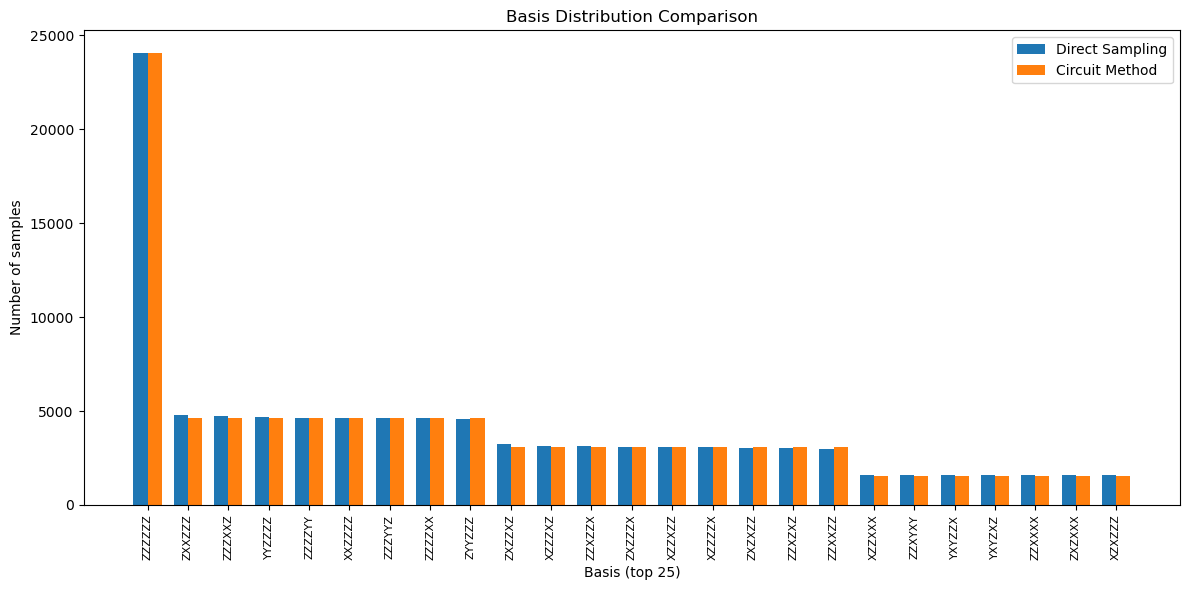

In [37]:
# Visualize it
def plot_basis_comparison(counts1, counts2, top_n=25):
    """Plot side-by-side comparison of basis counts."""
    # Get top N bases
    top_bases = [basis for basis, _ in counts1.most_common(top_n)]
    
    values1 = [counts1[basis] for basis in top_bases]
    values2 = [counts2.get(basis, 0) for basis in top_bases]
    
    x = np.arange(len(top_bases))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, values1, width, label='Direct Sampling')
    ax.bar(x + width/2, values2, width, label='Circuit Method')
    
    ax.set_xlabel('Basis (top ' + str(top_n) + ')')
    ax.set_ylabel('Number of samples')
    ax.set_title('Basis Distribution Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(top_bases, rotation=90, fontsize=8)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Use it:
plot_basis_comparison(counts_direct, counts_circuit, top_n=25)